<a href="https://colab.research.google.com/github/luongnhuy96/Project_Bootcamp_AI_Model_for_Customer_Growth_and_Retention/blob/main/Project_Bootcamp_AI_Model_for_Customer_Growth_and_Retention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pwd
!ls /content/drive

/content
MyDrive


In [7]:
!ls /content/drive/MyDrive/Project_Bootcamp_AI_Model_for_Customer/

customers.csv  transactions.csv


In [8]:
!ls /content/drive/MyDrive/Project_Bootcamp_AI_Model_for_Customer/customers.csv

/content/drive/MyDrive/Project_Bootcamp_AI_Model_for_Customer/customers.csv


In [18]:
import pandas as pd
import numpy as np


In [9]:
cus = pd.read_csv('/content/drive/MyDrive/Project_Bootcamp_AI_Model_for_Customer/customers.csv')
cus.head()

,customer_id,signup_date,true_lifetime_days
0,C00000,2025-08-22,204
1,C00001,2025-03-07,365
2,C00002,2025-08-18,48
3,C00003,2025-09-22,84
4,C00004,2025-05-28,113


In [10]:
import pandas as pd

trans = pd.read_csv('/content/drive/MyDrive/Project_Bootcamp_AI_Model_for_Customer/transactions.csv')
trans.head()

,customer_id,transaction_date,amount
0,C00000,2025-09-10,195.78
1,C00000,2025-09-12,50.87
2,C00000,2025-10-01,133.25
3,C00000,2025-10-16,37.44
4,C00000,2025-10-18,101.95


# 1. Customer Value Foundations

In [19]:

# Ensure datetime format
trans['transaction_date'] = pd.to_datetime(trans['transaction_date'])

# Snapshot date = ngày sau giao dịch cuối cùng
snapshot_date = trans['transaction_date'].max() + pd.Timedelta(days=1)

snapshot_date



Timestamp('2026-01-01 00:00:00')

In [20]:
#Tính RFM
rfm = (
    trans
    .groupby('customer_id')
    .agg(
        recency=('transaction_date', lambda x: (snapshot_date - x.max()).days),
        frequency=('transaction_date', 'count'),
        monetary=('amount', 'mean')
    )
    .reset_index()
)

rfm.head()


,customer_id,recency,frequency,monetary
0,C00000,1,12,101.904167
1,C00001,12,19,64.655789
2,C00002,97,11,82.785455
3,C00003,44,4,28.677500
4,C00004,109,19,106.260000


In [21]:
#RFM Scoring (1–5)
rfm['R_score'] = pd.qcut(
    rfm['recency'],
    q=5,
    labels=[5, 4, 3, 2, 1]
)

rfm['F_score'] = pd.qcut(
    rfm['frequency'].rank(method='first'),
    q=5,
    labels=[1, 2, 3, 4, 5]
)

rfm['M_score'] = pd.qcut(
    rfm['monetary'],
    q=5,
    labels=[1, 2, 3, 4, 5]
)


In [22]:
rfm['RFM_segment'] = (
    rfm['R_score'].astype(str) +
    rfm['F_score'].astype(str) +
    rfm['M_score'].astype(str)
)

rfm[['customer_id', 'recency', 'frequency', 'monetary', 'RFM_segment']].head()


,customer_id,recency,frequency,monetary,RFM_segment
0,C00000,1,12,101.904167,535
1,C00001,12,19,64.655789,444
2,C00002,97,11,82.785455,234
3,C00003,44,4,28.677500,312
4,C00004,109,19,106.260000,245


In [24]:
#PHÂN NHÓM KHÁCH HÀNG
# 5.1 High-value / At-risk
def value_risk_segment(row):
    if row['F_score'] >= 4 and row['M_score'] >= 4 and row['R_score'] >= 3:
        return 'High-value'
    elif row['F_score'] >= 4 and row['M_score'] >= 4 and row['R_score'] <= 2:
        return 'At-risk'
    else:
        return 'Other'


rfm['value_segment'] = rfm.apply(value_risk_segment, axis=1)

rfm['value_segment'].value_counts()




,count
value_segment,
Other,2415
High-value,373
At-risk,104


In [26]:
#5.2 New / Loyal / Hibernating
def lifecycle_segment(row):
    if row['R_score'] >= 4 and row['F_score'] <= 2:
        return 'New'
    elif row['R_score'] >= 4 and row['F_score'] >= 4:
        return 'Loyal'
    elif row['R_score'] <= 2 and row['F_score'] <= 2:
        return 'Hibernating'
    else:
        return 'Others'

rfm['lifecycle_segment'] = rfm.apply(lifecycle_segment, axis=1)

rfm['lifecycle_segment'].value_counts()




,count
lifecycle_segment,
Others,1301
Loyal,718
Hibernating,669
New,204


In [27]:
rfm.head()

,customer_id,recency,frequency,monetary,R_score,F_score,M_score,RFM_segment,value_segment,lifecycle_segment
0,C00000,1,12,101.904167,5,3,5,535,Other,Others
1,C00001,12,19,64.655789,4,4,4,444,High-value,Loyal
2,C00002,97,11,82.785455,2,3,4,234,Other,Others
3,C00003,44,4,28.677500,3,1,2,312,Other,Others
4,C00004,109,19,106.260000,2,4,5,245,At-risk,Others


In [28]:
rfm.to_csv('rfm_features.csv', index=False)

RFM analysis provides an initial understanding of customer value and lifecycle position.
High-value customers are identified by high frequency and monetary scores, while at-risk customers are those who historically generated high value but have not engaged recently.
However, RFM alone is descriptive and cannot reliably predict future churn, motivating the use of predictive and probabilistic models in subsequent sections.

# 2. Churn Prediction as Classification

In [54]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report,
    precision_recall_curve, roc_curve
)

import matplotlib.pyplot as plt


In [55]:

trans['transaction_date'] = pd.to_datetime(trans['transaction_date'])

# "toàn bộ data" snapshot (ngày sau giao dịch cuối cùng)
global_snapshot = trans['transaction_date'].max() + pd.Timedelta(days=1)
global_snapshot


Timestamp('2026-01-01 00:00:00')

1) Chọn feature snapshot



In [57]:
T0 = global_snapshot - pd.Timedelta(days=90)   # feature snapshot time
T0

trans_feat = trans[trans['transaction_date'] <= T0].copy()
trans_feat.shape

(25801, 3)

In [60]:
#RFM tại 𝑇0

def make_rfm_at_T0(trans_feat, T0):
    rfm = (
        trans_feat.groupby('customer_id')
        .agg(
            recency=('transaction_date', lambda x: (T0 - x.max()).days),
            frequency=('transaction_date', 'count'),
            monetary=('amount', 'mean')
        )
        .reset_index()
    )
    return rfm

#Frequency trend tại T0

def make_trend_at_T0(trans_feat, T0):
    def freq_window(days):
        start = T0 - pd.Timedelta(days=days)
        tmp = trans_feat[(trans_feat['transaction_date'] > start) & (trans_feat['transaction_date'] <= T0)]
        return tmp.groupby('customer_id').size().rename(f'freq_{days}')

    f7 = freq_window(7)
    f30 = freq_window(30)
    f90 = freq_window(90)

    trend = pd.concat([f7, f30, f90], axis=1).reset_index().fillna(0)
    eps = 1e-6
    trend['trend_7_30'] = trend['freq_7'] / (trend['freq_30'] + eps)
    trend['trend_30_90'] = trend['freq_30'] / (trend['freq_90'] + eps)
    return trend



In [61]:
#3) Hàm tạo LABEL churn trong tương lai

def make_future_churn_label(trans, T0, horizon_days):
    end = T0 + pd.Timedelta(days=horizon_days)
    trans_future = trans[(trans['transaction_date'] > T0) & (trans['transaction_date'] <= end)]

    active_in_future = trans_future.groupby('customer_id').size().rename('future_txn_cnt').reset_index()

    # tất cả customer xuất hiện trước T0 (có lịch sử)
    customers_hist = trans[trans['transaction_date'] <= T0]['customer_id'].drop_duplicates()
    base = pd.DataFrame({'customer_id': customers_hist})

    base = base.merge(active_in_future, on='customer_id', how='left').fillna({'future_txn_cnt': 0})
    base['churn'] = (base['future_txn_cnt'] == 0).astype(int)
    return base[['customer_id', 'churn']]



In [62]:
#4) Build dataset cho mỗi horizon (30/60/90)
def build_dataset_time_cutoff(trans, T0, horizon_days):
    trans_feat = trans[trans['transaction_date'] <= T0].copy()

    rfm = make_rfm_at_T0(trans_feat, T0)
    trend = make_trend_at_T0(trans_feat, T0)
    label = make_future_churn_label(trans, T0, horizon_days)

    df = label.merge(rfm, on='customer_id', how='left').merge(trend, on='customer_id', how='left')

    # Nếu có customer có label nhưng thiếu rfm (hiếm), fill
    df[['recency','frequency','monetary']] = df[['recency','frequency','monetary']].fillna(0)
    df[['freq_7','freq_30','freq_90','trend_7_30','trend_30_90']] = df[['freq_7','freq_30','freq_90','trend_7_30','trend_30_90']].fillna(0)

    feature_cols = [
        # RFM
        'recency', 'frequency', 'monetary',
        # Frequency trend
        'freq_7', 'freq_30', 'freq_90',
        'trend_7_30', 'trend_30_90'
    ]

    X = df[feature_cols].copy()
    y = df['churn'].copy()
    return df, X, y, feature_cols



In [63]:
#5) Models (Logistic / Tree)
def get_models():
    logit = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=2000, class_weight='balanced'))
    ])

    tree = RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight='balanced',
        min_samples_leaf=5,
        n_jobs=-1
    )
    return logit, tree



In [64]:
#6) Evaluation (AUC, PR, Confusion matrix + curves)
def evaluate_model(model, X_train, y_train, X_test, y_test, title):
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:, 1]
    pred = (proba >= 0.5).astype(int)

    roc = roc_auc_score(y_test, proba)
    pr  = average_precision_score(y_test, proba)

    print(f"\n=== {title} ===")
    print(f"ROC-AUC: {roc:.4f}")
    print(f"PR-AUC : {pr:.4f}")
    print("Confusion Matrix (threshold=0.5):")
    print(confusion_matrix(y_test, pred))
    print("\nClassification report:")
    print(classification_report(y_test, pred, digits=4))

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f"ROC Curve - {title}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    # PR curve
    precision, recall, _ = precision_recall_curve(y_test, proba)
    plt.figure()
    plt.plot(recall, precision)
    plt.title(f"Precision-Recall Curve - {title}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

    return model, proba



In [65]:
#7) Top features

def top_features_logistic(fitted_logit, feature_cols, top_k=10):
    coef = fitted_logit.named_steps['clf'].coef_[0]
    df = pd.DataFrame({
        'feature': feature_cols,
        'coef': coef,
        'abs_coef': np.abs(coef)
    }).sort_values('abs_coef', ascending=False).head(top_k)
    return df

def top_features_tree(fitted_tree, feature_cols, top_k=10):
    imp = fitted_tree.feature_importances_
    df = pd.DataFrame({
        'feature': feature_cols,
        'importance': imp
    }).sort_values('importance', ascending=False).head(top_k)
    return df



TIME-CUTOFF SETUP | Feature time T0=2025-10-03 | Horizon=30 days
Churn rate (h=30): 0.551 | N=2267

=== Logistic (h=30) ===
ROC-AUC: 0.9192
PR-AUC : 0.9443
Confusion Matrix (threshold=0.5):
[[189  15]
 [ 55 195]]

Classification report:
              precision    recall  f1-score   support

           0     0.7746    0.9265    0.8438       204
           1     0.9286    0.7800    0.8478       250

    accuracy                         0.8458       454
   macro avg     0.8516    0.8532    0.8458       454
weighted avg     0.8594    0.8458    0.8460       454



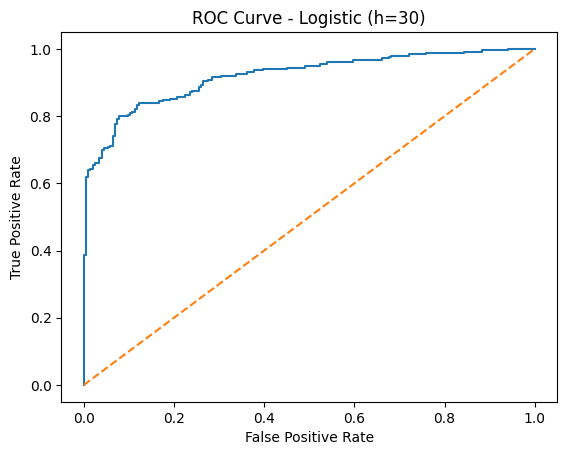

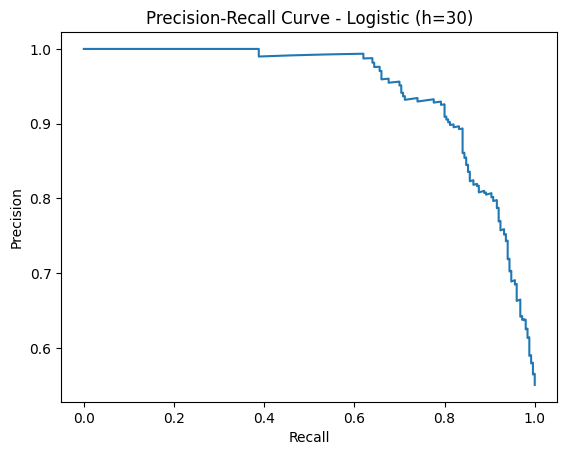


Top features - Logistic (|coef|):


,feature,coef,abs_coef
0,recency,2.687407,2.687407
4,freq_30,-0.703440,0.703440
3,freq_7,-0.432584,0.432584
1,frequency,0.355097,0.355097
7,trend_30_90,-0.210741,0.210741
6,trend_7_30,0.142056,0.142056
2,monetary,0.034659,0.034659
5,freq_90,-0.030565,0.030565



=== RandomForest (h=30) ===
ROC-AUC: 0.9083
PR-AUC : 0.9368
Confusion Matrix (threshold=0.5):
[[186  18]
 [ 57 193]]

Classification report:
              precision    recall  f1-score   support

           0     0.7654    0.9118    0.8322       204
           1     0.9147    0.7720    0.8373       250

    accuracy                         0.8348       454
   macro avg     0.8401    0.8419    0.8348       454
weighted avg     0.8476    0.8348    0.8350       454



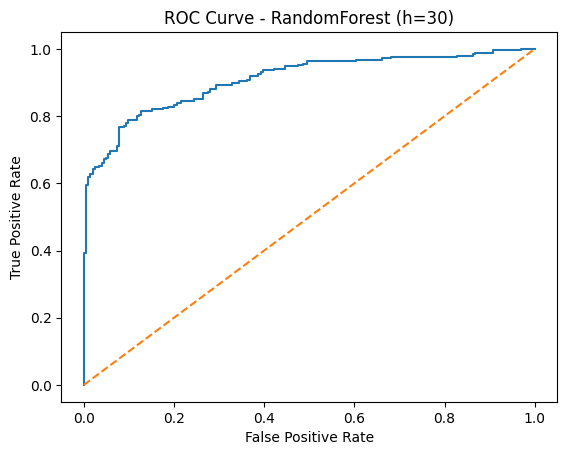

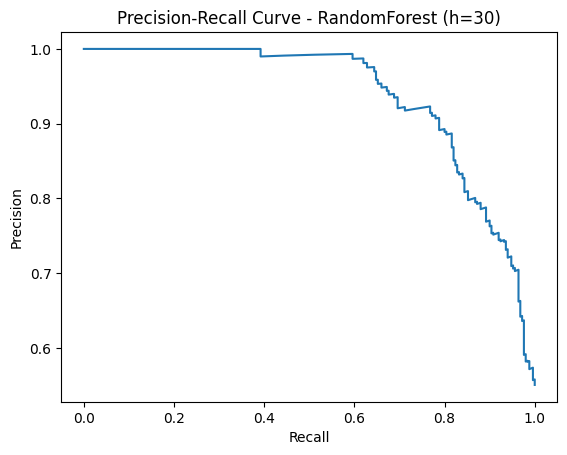


Top features - RandomForest (importance):


,feature,importance
0,recency,0.266114
7,trend_30_90,0.253721
4,freq_30,0.175932
5,freq_90,0.103661
3,freq_7,0.057868
6,trend_7_30,0.052553
2,monetary,0.047943
1,frequency,0.042209



TIME-CUTOFF SETUP | Feature time T0=2025-10-03 | Horizon=60 days
Churn rate (h=60): 0.524 | N=2267

=== Logistic (h=60) ===
ROC-AUC: 0.9279
PR-AUC : 0.9474
Confusion Matrix (threshold=0.5):
[[198  18]
 [ 46 192]]

Classification report:
              precision    recall  f1-score   support

           0     0.8115    0.9167    0.8609       216
           1     0.9143    0.8067    0.8571       238

    accuracy                         0.8590       454
   macro avg     0.8629    0.8617    0.8590       454
weighted avg     0.8654    0.8590    0.8589       454



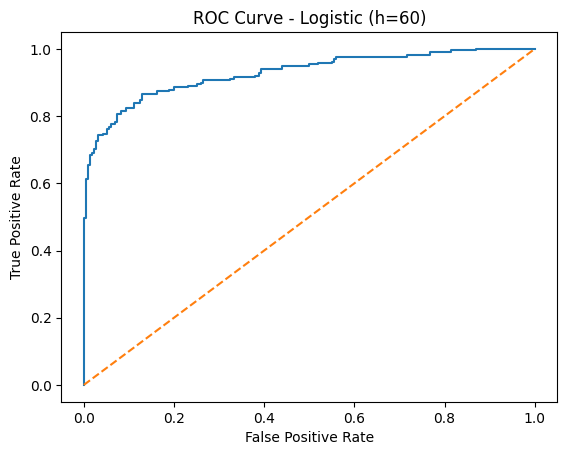

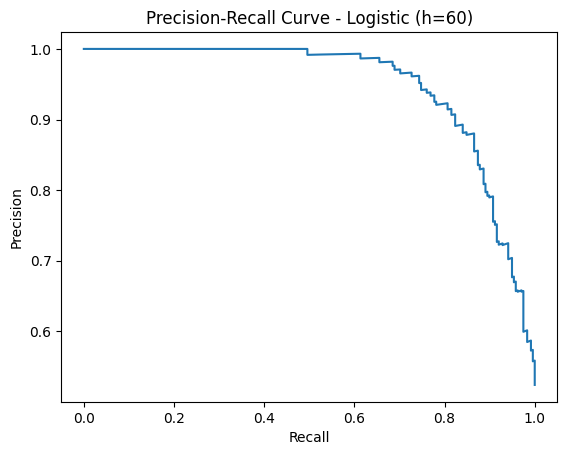


Top features - Logistic (|coef|):


,feature,coef,abs_coef
0,recency,2.692545,2.692545
4,freq_30,-0.993433,0.993433
3,freq_7,-0.537892,0.537892
1,frequency,0.358184,0.358184
5,freq_90,0.245179,0.245179
7,trend_30_90,-0.065116,0.065116
6,trend_7_30,0.025524,0.025524
2,monetary,-0.011970,0.011970



=== RandomForest (h=60) ===
ROC-AUC: 0.9217
PR-AUC : 0.9433
Confusion Matrix (threshold=0.5):
[[197  19]
 [ 45 193]]

Classification report:
              precision    recall  f1-score   support

           0     0.8140    0.9120    0.8603       216
           1     0.9104    0.8109    0.8578       238

    accuracy                         0.8590       454
   macro avg     0.8622    0.8615    0.8590       454
weighted avg     0.8645    0.8590    0.8590       454



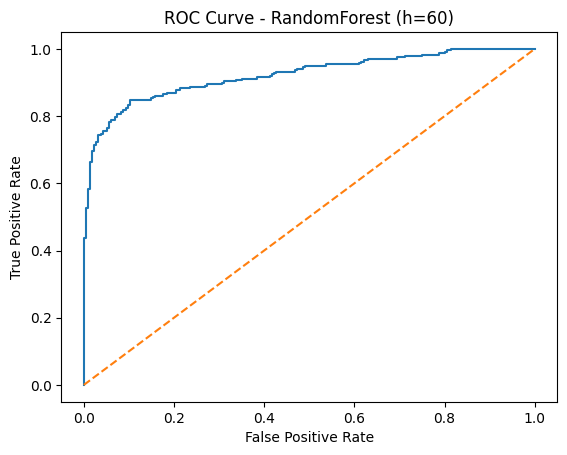

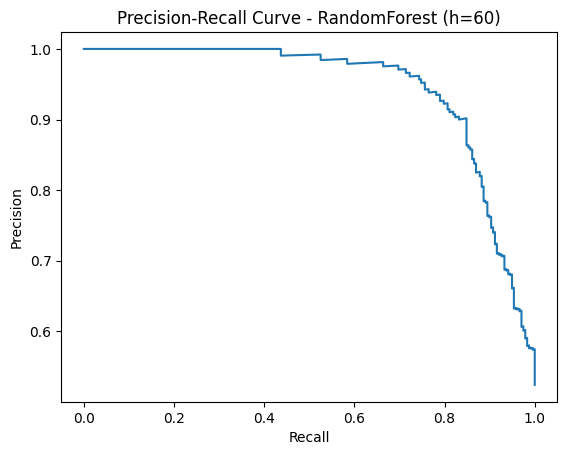


Top features - RandomForest (importance):


,feature,importance
0,recency,0.270543
7,trend_30_90,0.258730
4,freq_30,0.163875
5,freq_90,0.094746
3,freq_7,0.069748
6,trend_7_30,0.053893
2,monetary,0.049482
1,frequency,0.038983



TIME-CUTOFF SETUP | Feature time T0=2025-10-03 | Horizon=90 days
Churn rate (h=90): 0.519 | N=2267

=== Logistic (h=90) ===
ROC-AUC: 0.9212
PR-AUC : 0.9417
Confusion Matrix (threshold=0.5):
[[201  17]
 [ 45 191]]

Classification report:
              precision    recall  f1-score   support

           0     0.8171    0.9220    0.8664       218
           1     0.9183    0.8093    0.8604       236

    accuracy                         0.8634       454
   macro avg     0.8677    0.8657    0.8634       454
weighted avg     0.8697    0.8634    0.8633       454



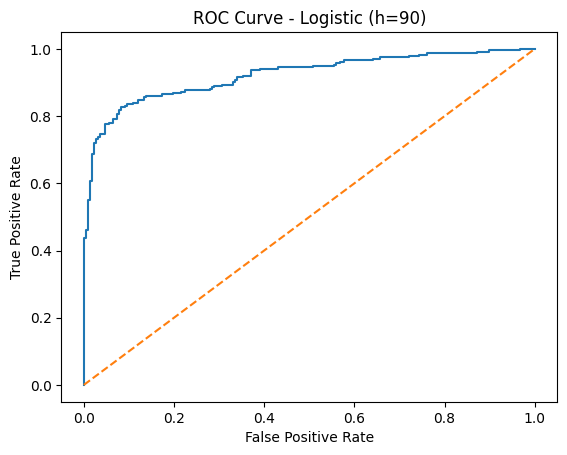

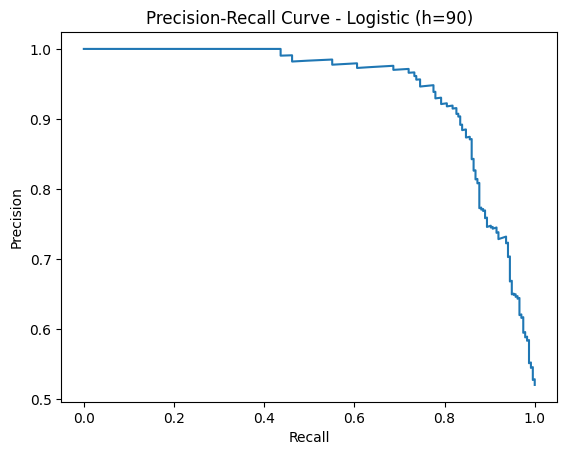


Top features - Logistic (|coef|):


,feature,coef,abs_coef
0,recency,2.952847,2.952847
4,freq_30,-0.845258,0.845258
3,freq_7,-0.750240,0.750240
1,frequency,0.443532,0.443532
5,freq_90,0.234056,0.234056
6,trend_7_30,0.088757,0.088757
2,monetary,0.085868,0.085868
7,trend_30_90,-0.014442,0.014442



=== RandomForest (h=90) ===
ROC-AUC: 0.9227
PR-AUC : 0.9438
Confusion Matrix (threshold=0.5):
[[196  22]
 [ 43 193]]

Classification report:
              precision    recall  f1-score   support

           0     0.8201    0.8991    0.8578       218
           1     0.8977    0.8178    0.8559       236

    accuracy                         0.8568       454
   macro avg     0.8589    0.8584    0.8568       454
weighted avg     0.8604    0.8568    0.8568       454



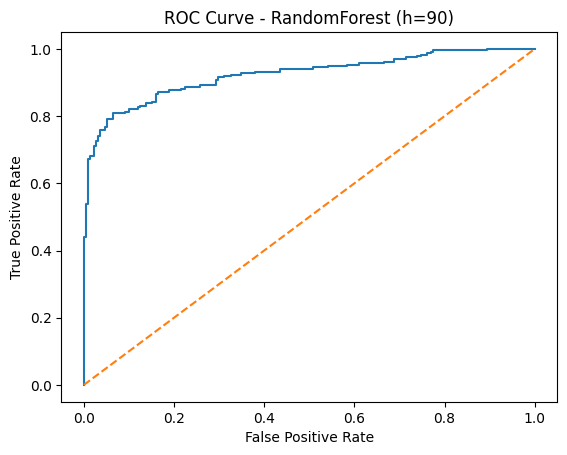

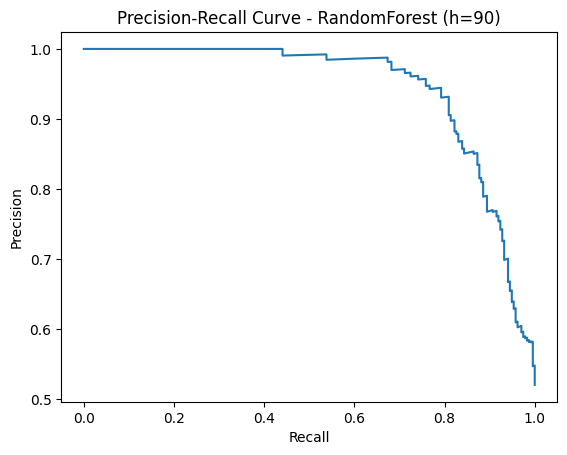


Top features - RandomForest (importance):


,feature,importance
0,recency,0.270884
7,trend_30_90,0.251423
4,freq_30,0.169485
5,freq_90,0.094433
3,freq_7,0.068929
6,trend_7_30,0.055056
2,monetary,0.048751
1,frequency,0.041040


In [66]:
#8) RUN cho 30 / 60 / 90 ngày
horizons = [30, 60, 90]
results_part2 = {}

for h in horizons:
    print("\n" + "="*95)
    print(f"TIME-CUTOFF SETUP | Feature time T0={T0.date()} | Horizon={h} days")

    df, X, y, feature_cols = build_dataset_time_cutoff(trans, T0, h)
    print(f"Churn rate (h={h}): {y.mean():.3f} | N={len(y)}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    logit, tree = get_models()

    # Logistic
    fitted_logit, _ = evaluate_model(logit, X_train, y_train, X_test, y_test, title=f"Logistic (h={h})")
    top_logit = top_features_logistic(fitted_logit, feature_cols, top_k=10)
    print("\nTop features - Logistic (|coef|):")
    display(top_logit)

    # Tree
    fitted_tree, _ = evaluate_model(tree, X_train, y_train, X_test, y_test, title=f"RandomForest (h={h})")
    top_tree = top_features_tree(fitted_tree, feature_cols, top_k=10)
    print("\nTop features - RandomForest (importance):")
    display(top_tree)

    results_part2[h] = {
        "df": df,
        "X": X,
        "y": y,
        "feature_cols": feature_cols,
        "logit_model": fitted_logit,
        "tree_model": fitted_tree,
        "top_logit": top_logit,
        "top_tree": top_tree
    }



In [67]:
#9) (Tuỳ chọn) Xuất churn_probability để dùng ở phần cuối (giữ 20%)
h = 60
df = results_part2[h]["df"].copy()
X  = results_part2[h]["X"]

best_model = results_part2[h]["tree_model"]  # hoặc logit_model
df["churn_probability"] = best_model.predict_proba(X)[:, 1]

df[['customer_id','churn','churn_probability']].head()


,customer_id,churn,churn_probability
0,C00000,0,0.165449
1,C00001,0,0.447361
2,C00002,1,0.256395
3,C00004,1,0.790275
4,C00006,0,0.316147


# 3. Churn via BG-NBD

In [72]:
!pip -q install lifetimes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 10.8 MB/s eta 0:00:00


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes.utils import summary_data_from_transaction_data


In [70]:
# Transactions dùng cho BG-NBD (chỉ đến T0)
trans_bgnbd = trans[trans['transaction_date'] <= T0].copy()


In [74]:
#Tạo bảng summary (frequency, recency, T)
summary = summary_data_from_transaction_data(
    trans_bgnbd,
    customer_id_col='customer_id',
    datetime_col='transaction_date',
    observation_period_end=T0,
    monetary_value_col=None   # BG-NBD không dùng monetary
)

summary.head()


,frequency,recency,T
customer_id,,,
C00000,2.0,21.0,23.0
C00001,9.0,178.0,200.0
C00002,9.0,37.0,44.0
C00004,17.0,98.0,117.0
C00006,0.0,0.0,29.0


In [75]:
#Fit BG-NBD model
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(
    summary['frequency'],
    summary['recency'],
    summary['T']
)


<lifetimes.BetaGeoFitter: fitted with 2267 subjects, a: 0.24, alpha: 13.86, b: 1.79, r: 1.59>

In [76]:
#3.1 Tính xác suất customer còn “alive” tại T₀
summary['p_alive'] = bgf.conditional_probability_alive(
    summary['frequency'],
    summary['recency'],
    summary['T']
)

summary[['frequency', 'recency', 'T', 'p_alive']].head()


,frequency,recency,T,p_alive
customer_id,,,,
C00000,2.0,21.0,23.0,0.905904
C00001,9.0,178.0,200.0,0.929001
C00002,9.0,37.0,44.0,0.913364
C00004,17.0,98.0,117.0,0.802502
C00006,0.0,0.0,29.0,1.000000


In [77]:
#Expected #transactions
summary['exp_txn_60'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    60,
    summary['frequency'],
    summary['recency'],
    summary['T']
)

summary[['p_alive', 'exp_txn_60']].head()


,p_alive,exp_txn_60
customer_id,,
C00000,0.905904,4.584494
C00001,0.929001,2.674025
C00002,0.913364,9.105840
C00004,0.802502,6.517338
C00006,1.000000,1.931218


In [78]:
#5.1 Lấy churn label từ Part 2 (60 ngày)
churn_df = results_part2[60]["df"][['customer_id', 'churn']]


In [79]:
#5.2 Merge với BG-NBD output
compare_df = (
    churn_df
    .merge(summary.reset_index(), on='customer_id', how='inner')
)

compare_df[['customer_id', 'churn', 'p_alive', 'exp_txn_60']].head()




,customer_id,churn,p_alive,exp_txn_60
0,C00000,0,0.905904,4.584494
1,C00001,0,0.929001,2.674025
2,C00002,1,0.913364,9.105840
3,C00004,1,0.802502,6.517338
4,C00006,0,1.000000,1.931218


In [80]:
#6.1 P(alive) theo churn label

compare_df.groupby('churn')['p_alive'].mean()



,p_alive
churn,
0,0.904762
1,0.370004


<Figure size 600x400 with 0 Axes>

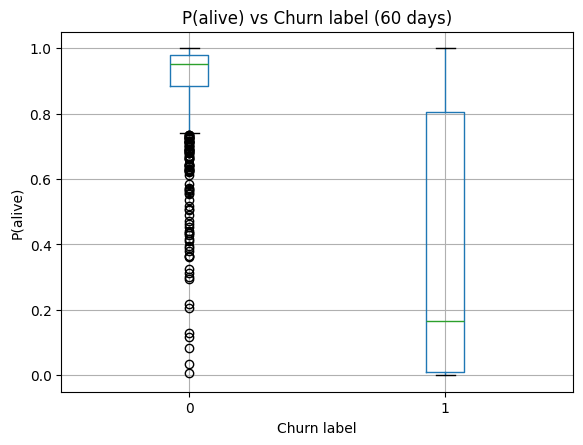

In [81]:
plt.figure(figsize=(6,4))
compare_df.boxplot(column='p_alive', by='churn')
plt.title('P(alive) vs Churn label (60 days)')
plt.suptitle('')
plt.xlabel('Churn label')
plt.ylabel('P(alive)')
plt.show()


In [82]:
compare_df[['churn','p_alive']].corr()


,churn,p_alive
churn,1.000000,-0.666744
p_alive,-0.666744,1.000000


In [83]:
compare_df['bgnbd_churn_score'] = 1 - compare_df['p_alive']
compare_df[['churn', 'bgnbd_churn_score']].head()


,churn,bgnbd_churn_score
0,0,0.094096
1,0,0.070999
2,1,0.086636
3,1,0.197498
4,0,0.000000


The estimated P(alive) shows a strong negative relationship with the churn labels obtained from the classification model.
Customers labeled as churned within the 60-day horizon tend to have significantly lower P(alive), confirming the consistency between probabilistic and classification-based approaches.

In addition, BG-NBD provides expected future transaction counts, which offer a longer-term and smoother view of customer activity compared to fixed-horizon churn classification.

In [84]:
compare_df['bgnbd_churn_score'] = 1 - compare_df['p_alive']
compare_df[['churn', 'bgnbd_churn_score']].head()


,churn,bgnbd_churn_score
0,0,0.094096
1,0,0.070999
2,1,0.086636
3,1,0.197498
4,0,0.000000


# 4. Churn with Survival Analysis

In [108]:
!pip -q install lifelines


In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lifelines import CoxPHFitter, WeibullAFTFitter


In [87]:
#1) Define duration & event
#1.1 Tạo “last transaction trước T0” và “first transaction” để đo thời gian
#1.1.1 Tách data trước & sau T0
trans['transaction_date'] = pd.to_datetime(trans['transaction_date'])

trans_pre  = trans[trans['transaction_date'] <= T0].copy()
trans_post = trans[trans['transaction_date'] > T0].copy()

print(trans_pre.shape, trans_post.shape)




(25801, 3) (20903, 3)


In [88]:
#1.1.2 Giao dịch đầu tiên của mỗi khách (start)
first_tx = (
    trans.groupby('customer_id')['transaction_date']
    .min()
    .reset_index()
    .rename(columns={'transaction_date': 'first_tx_date'})
)


In [89]:
#1.1.3 Giao dịch cuối trước T0 (để đảm bảo có lịch sử)
last_pre_tx = (
    trans_pre.groupby('customer_id')['transaction_date']
    .max()
    .reset_index()
    .rename(columns={'transaction_date': 'last_pre_tx_date'})
)


In [90]:
#1.2 Xác định event (churn) và duration
#1.2.1 Lấy last transaction sau T0
last_post_tx = (
    trans_post.groupby('customer_id')['transaction_date']
    .max()
    .reset_index()
    .rename(columns={'transaction_date': 'last_post_tx_date'})
)



In [91]:
#1.2.2 Tạo survival dataframe
end_obs = trans['transaction_date'].max()  # last observed day

surv = (
    last_pre_tx.merge(first_tx, on='customer_id', how='left')
               .merge(last_post_tx, on='customer_id', how='left')
)

surv['event'] = surv['last_post_tx_date'].isna().astype(int)

# stop time: nếu censored -> last_post_tx_date, nếu event -> T0
surv['stop_date'] = np.where(
    surv['event'] == 0,
    surv['last_post_tx_date'],
    T0
)

surv['stop_date'] = pd.to_datetime(surv['stop_date'])

# duration (days) từ first_tx_date -> stop_date
surv['duration'] = (surv['stop_date'] - surv['first_tx_date']).dt.days

surv[['customer_id','first_tx_date','last_pre_tx_date','last_post_tx_date','event','stop_date','duration']].head()


,customer_id,first_tx_date,last_pre_tx_date,last_post_tx_date,event,stop_date,duration
0,C00000,2025-09-10,2025-10-01,2025-12-31,0,2025-12-31,112
1,C00001,2025-03-17,2025-09-11,2025-12-20,0,2025-12-20,278
2,C00002,2025-08-20,2025-09-26,NaT,1,2025-10-03,44
3,C00004,2025-06-08,2025-09-14,NaT,1,2025-10-03,117
4,C00006,2025-09-04,2025-09-04,2025-11-25,0,2025-11-25,82


In [92]:
#1.2.3 Loại các duration <= 0
surv = surv[surv['duration'] > 0].copy()
surv['event'].value_counts()


,count
event,
1,1176
0,1091


In [93]:
#2) Feature set cho Survival
#2.1 Build RFM + trend tại T0
def make_rfm_at_T0(trans_feat, T0):
    rfm = (
        trans_feat.groupby('customer_id')
        .agg(
            recency=('transaction_date', lambda x: (T0 - x.max()).days),
            frequency=('transaction_date', 'count'),
            monetary=('amount', 'mean')
        )
        .reset_index()
    )
    return rfm

def make_trend_at_T0(trans_feat, T0):
    def freq_window(days):
        start = T0 - pd.Timedelta(days=days)
        tmp = trans_feat[(trans_feat['transaction_date'] > start) & (trans_feat['transaction_date'] <= T0)]
        return tmp.groupby('customer_id').size().rename(f'freq_{days}')

    f7  = freq_window(7)
    f30 = freq_window(30)
    f90 = freq_window(90)

    trend = pd.concat([f7, f30, f90], axis=1).reset_index().fillna(0)
    eps = 1e-6
    trend['trend_7_30'] = trend['freq_7']/(trend['freq_30']+eps)
    trend['trend_30_90'] = trend['freq_30']/(trend['freq_90']+eps)
    return trend

trans_feat = trans[trans['transaction_date'] <= T0].copy()

rfm_T0 = make_rfm_at_T0(trans_feat, T0)
trend_T0 = make_trend_at_T0(trans_feat, T0)

feat_T0 = rfm_T0.merge(trend_T0, on='customer_id', how='left').fillna(0)
feat_T0.head()




,customer_id,recency,frequency,monetary,freq_7,freq_30,freq_90,trend_7_30,trend_30_90
0,C00000,2,3,126.633333,1.0,3.0,3.0,0.333333,1.000000
1,C00001,22,11,56.435455,0.0,1.0,5.0,0.000000,0.200000
2,C00002,7,11,82.785455,0.0,5.0,11.0,0.000000,0.454545
3,C00004,19,19,106.260000,0.0,1.0,13.0,0.000000,0.076923
4,C00006,29,1,20.200000,0.0,1.0,1.0,0.000000,0.999999


In [94]:
#2.2 Merge survival targets + features
surv_df = surv.merge(feat_T0, on='customer_id', how='left').fillna(0)

surv_df[['duration','event','recency','frequency','monetary','freq_7','freq_30','freq_90','trend_7_30','trend_30_90']].head()


,duration,event,recency,frequency,monetary,freq_7,freq_30,freq_90,trend_7_30,trend_30_90
0,112,0,2,3,126.633333,1.0,3.0,3.0,0.333333,1.000000
1,278,0,22,11,56.435455,0.0,1.0,5.0,0.000000,0.200000
2,44,1,7,11,82.785455,0.0,5.0,11.0,0.000000,0.454545
3,117,1,19,19,106.260000,0.0,1.0,13.0,0.000000,0.076923
4,82,0,29,1,20.200000,0.0,1.0,1.0,0.000000,0.999999


In [95]:
#3) Fit CoxPH (đúng yêu cầu)
cox_cols = [
    'duration','event',
    'recency','frequency','monetary',
    'freq_7','freq_30','freq_90',
    'trend_7_30','trend_30_90'
]

cox_data = surv_df[cox_cols].copy()

cph = CoxPHFitter()
cph.fit(cox_data, duration_col='duration', event_col='event')

cph.print_summary()


<lifelines.CoxPHFitter: fitted with 2267 total observations, 1091 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 2267
number of events observed = 1176
   partial log-likelihood = -7498.12
         time fit was run = 2026-01-18 16:30:20 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
recency     -0.00      1.00      0.00           -0.01           -0.00                0.99                1.00
frequency   -0.06      0.94      0.00           -0.07           -0.05                0.93                0.95
monetary    -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
freq_7       0.07      1.07      0.21           -0.35            0.49                0.70                1.63
freq_30     -0.39      0.68      0.06           -0.51           -0.27                0.60                0.77
freq_90      0.06      1.06      0.01            0.03            0.09                1.03                1.09
trend_7_30  -1.83      0.16      0.46           -2.74           -0.93                0.06                0.39
trend_30_90 -0.56      0.57      0.30           -1.14            0.03                0.32                1.03

             cmp to      z      p  -log2(p)
covariate                                  
recency        0.00  -7.59 <0.005     44.85
frequency      0.00 -12.43 <0.005    115.48
monetary       0.00  -0.41   0.68      0.56
freq_7         0.00   0.32   0.75      0.42
freq_30        0.00  -6.15 <0.005     30.30
freq_90        0.00   4.13 <0.005     14.77
trend_7_30     0.00  -3.97 <0.005     13.79
trend_30_90    0.00  -1.87   0.06      4.02
---
Concordance = 0.76
Partial AIC = 15012.23
log-likelihood ratio test = 741.71 on 8 df
-log2(p) of ll-ratio test = 512.00

In [96]:
#4) Fit Weibull (AFT)
aft = WeibullAFTFitter()
aft.fit(cox_data, duration_col='duration', event_col='event')

aft.print_summary()


<lifelines.WeibullAFTFitter: fitted with 2267 total observations, 1091 right-censored observations>
             duration col = 'duration'
                event col = 'event'
   number of observations = 2267
number of events observed = 1176
           log-likelihood = -6986.32
         time fit was run = 2026-01-18 16:30:45 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                    
lambda_ freq_30      0.14      1.15      0.02            0.10            0.18                1.10                1.20
        freq_7      -0.01      0.99      0.07           -0.15            0.13                0.86                1.14
        freq_90     -0.02      0.98      0.00           -0.03           -0.01                0.97                0.99
        frequency    0.02      1.02      0.00            0.01            0.02                1.02                1.02
        monetary     0.00      1.00      0.00           -0.00            0.00                1.00                1.00
        recency      0.00      1.00      0.00            0.00            0.00                1.00                1.00
        trend_30_90  0.09      1.10      0.10           -0.10            0.29                0.90                1.33
        trend_7_30   0.60      1.82      0.16            0.29            0.91                1.33                2.48
        Intercept    4.98    145.74      0.04            4.91            5.05              135.68              156.55
rho_    Intercept    1.08      2.95      0.02            1.03            1.13                2.81                3.09

                     cmp to      z      p  -log2(p)
param   covariate                                  
lambda_ freq_30        0.00   6.61 <0.005     34.64
        freq_7         0.00  -0.16   0.87      0.20
        freq_90        0.00  -4.13 <0.005     14.78
        frequency      0.00  11.52 <0.005     99.57
        monetary       0.00   0.43   0.67      0.58
        recency        0.00   6.39 <0.005     32.44
        trend_30_90    0.00   0.95   0.34      1.55
        trend_7_30     0.00   3.77 <0.005     12.56
        Intercept      0.00 136.50 <0.005       inf
rho_    Intercept      0.00  45.26 <0.005       inf
---
Concordance = 0.76
AIC = 13992.63
log-likelihood ratio test = 673.61 on 8 df
-log2(p) of ll-ratio test = 463.29

In [97]:
#5) Predict survival curve (đúng deliverable)
#5.1 Survival curve cho 1 khách (CoxPH)
one = cox_data.drop(columns=['duration','event']).iloc[[0]]

sf = cph.predict_survival_function(one)
sf.head()


,0
1.0,0.999844
2.0,0.999689
3.0,0.999534
6.0,0.999223
7.0,0.999067


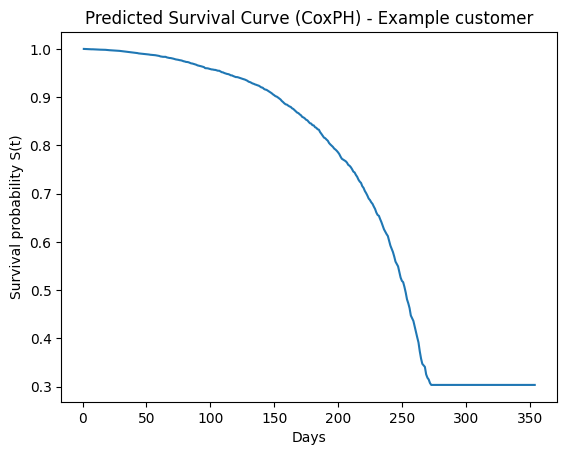

In [98]:
plt.figure()
plt.plot(sf.index, sf.values)
plt.title("Predicted Survival Curve (CoxPH) - Example customer")
plt.xlabel("Days")
plt.ylabel("Survival probability S(t)")
plt.show()


In [99]:
#5.2 Survival curve cho nhóm (ví dụ: top 5 churn risk)
surv_df['risk_score'] = cph.predict_partial_hazard(cox_data).values

top_risk = surv_df.sort_values('risk_score', ascending=False).head(5).index


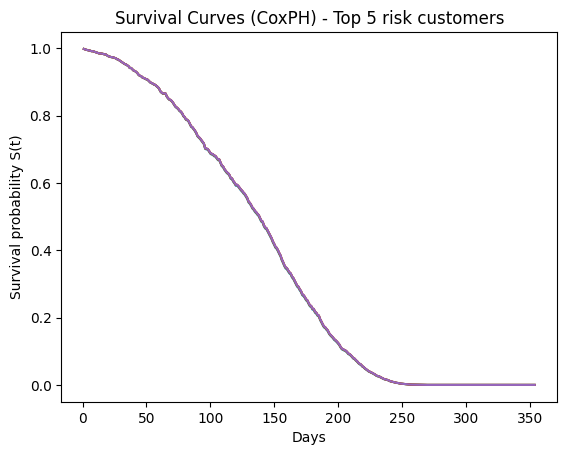

In [100]:
plt.figure()
for idx in top_risk:
    row = cox_data.drop(columns=['duration','event']).iloc[[idx]]
    sf = cph.predict_survival_function(row)
    plt.plot(sf.index, sf.values)

plt.title("Survival Curves (CoxPH) - Top 5 risk customers")
plt.xlabel("Days")
plt.ylabel("Survival probability S(t)")
plt.show()


6) Expected remaining lifetime (deliverable)

In [101]:
def expected_lifetime_from_survival(sf):
    # sf: DataFrame survival function, index=time, values=S(t)
    t = sf.index.values
    s = sf.values.flatten()
    return np.trapz(s, t)

# ví dụ cho 1 khách
sf1 = cph.predict_survival_function(one)
expected_days = expected_lifetime_from_survival(sf1)
expected_days


/tmp/ipython-input-3629378528.py:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(s, t)


np.float64(254.66086332452983)

# 5. CLV Modeling

5. CLV Modeling

In [106]:
!pip -q install lifetimes


In [113]:
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data


In [124]:
# đảm bảo datetime
trans['transaction_date'] = pd.to_datetime(trans['transaction_date'])


In [125]:
#1) Chuẩn bị dữ liệu train đến thời điểm T0
trans_clv = trans[trans['transaction_date'] <= T0].copy()
trans_clv.shape


(25801, 3)

In [126]:
#2) Tạo bảng summary cho BG-NBD + Gamma–Gamma
summary = summary_data_from_transaction_data(
    trans_clv,
    customer_id_col='customer_id',
    datetime_col='transaction_date',
    observation_period_end=T0,
    monetary_value_col='amount',
    freq='D'   # đơn vị ngày (phổ biến trong buổi 2)
)

summary.head()


,frequency,recency,T,monetary_value
customer_id,,,,
C00000,2.0,21.0,23.0,92.060000
C00001,9.0,178.0,200.0,61.631111
C00002,9.0,37.0,44.0,86.307778
C00004,17.0,98.0,117.0,109.965882
C00006,0.0,0.0,29.0,0.000000


In [127]:
#3) Fit BG-NBD
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])



<lifetimes.BetaGeoFitter: fitted with 2267 subjects, a: 0.24, alpha: 13.86, b: 1.79, r: 1.59>

In [128]:
#4) Predict bằng BG-NBD
#4.1 Probability customer is alive
summary['p_alive'] = bgf.conditional_probability_alive(
    summary['frequency'], summary['recency'], summary['T']
)

summary[['frequency','recency','T','p_alive']].head()


,frequency,recency,T,p_alive
customer_id,,,,
C00000,2.0,21.0,23.0,0.905904
C00001,9.0,178.0,200.0,0.929001
C00002,9.0,37.0,44.0,0.913364
C00004,17.0,98.0,117.0,0.802502
C00006,0.0,0.0,29.0,1.000000


In [129]:
#4.2 Expected number of future transactions trong horizon T
HORIZON_DAYS = 180  # ví dụ 180 ngày

summary['exp_txn_T'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    HORIZON_DAYS,
    summary['frequency'], summary['recency'], summary['T']
)

summary[['p_alive','exp_txn_T']].head()


,p_alive,exp_txn_T
customer_id,,
C00000,0.905904,11.957824
C00001,0.929001,7.628474
C00002,0.913364,24.445510
C00004,0.802502,18.238524
C00006,1.000000,5.031097


In [130]:
#5) Fit Gamma–Gamma
#5.1 Lọc dữ liệu hợp lệ
gg_data = summary[(summary['frequency'] > 0) & (summary['monetary_value'] > 0)].copy()
gg_data.shape


(2075, 6)

In [131]:
#5.2 Fit model
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(gg_data['frequency'], gg_data['monetary_value'])


<lifetimes.GammaGammaFitter: fitted with 2075 subjects, p: 3.83, q: 0.69, v: 3.78>

In [132]:
#6) Compute monetary value + CLV
#6.1 Expected monetary value (expected profit per transaction)
gg_data['exp_monetary_value'] = ggf.conditional_expected_average_profit(
    gg_data['frequency'], gg_data['monetary_value']
)

gg_data[['monetary_value','exp_monetary_value']].head()


,monetary_value,exp_monetary_value
customer_id,,
C00000,92.060000,97.881961
C00001,61.631111,62.609948
C00002,86.307778,87.508930
C00004,109.965882,110.711463
C00007,88.840000,91.625287


In [133]:
#6.2 CLV over time horizon T (Discounted)
ANNUAL_DISCOUNT = 0.10
DAILY_DISCOUNT = ANNUAL_DISCOUNT / 365

gg_data['clv_T'] = ggf.customer_lifetime_value(
    bgf,
    gg_data['frequency'],
    gg_data['recency'],
    gg_data['T'],
    gg_data['monetary_value'],
    time=HORIZON_DAYS,
    discount_rate=DAILY_DISCOUNT,
    freq='D'
)

gg_data[['p_alive','exp_txn_T','exp_monetary_value','clv_T']].head()


,p_alive,exp_txn_T,exp_monetary_value,clv_T
customer_id,,,,
C00000,0.905904,11.957824,97.881961,17434.689460
C00001,0.929001,7.628474,62.609948,8675.571660
C00002,0.913364,24.445510,87.508930,33393.715301
C00004,0.802502,18.238524,110.711463,34527.401763
C00007,0.939873,11.638114,91.625287,16797.575093


In [134]:
#7) Tạo bảng kết quả CLV cuối cùng để dùng cho project
clv_df = gg_data.reset_index()[[
    'customer_id',
    'frequency','recency','T',
    'p_alive',
    'exp_txn_T',
    'monetary_value','exp_monetary_value',
    'clv_T'
]].copy()

clv_df.sort_values('clv_T', ascending=False).head(15)


,customer_id,frequency,recency,T,p_alive,exp_txn_T,monetary_value,exp_monetary_value,clv_T
100,C00158,33.0,59.0,59.0,0.993037,71.193172,160.111818,160.617431,183278.979116
1209,C01754,40.0,89.0,90.0,0.991389,62.265018,140.915500,141.293810,146642.220046
1712,C02473,18.0,28.0,28.0,0.987547,64.905960,122.762778,123.524137,121908.424728
1637,C02364,22.0,153.0,155.0,0.986417,22.517233,298.291818,299.557735,119213.231644
798,C01134,30.0,69.0,69.0,0.992364,57.949465,122.828667,123.284841,116055.654641
1982,C02865,35.0,82.0,84.0,0.986104,57.478753,111.609429,111.974468,106526.889348
418,C00600,28.0,109.0,109.0,0.991838,38.039734,156.757500,157.344006,101703.208880
342,C00490,42.0,212.0,212.0,0.994494,32.015180,159.410952,159.806668,94137.721899
185,C00268,31.0,97.0,99.0,0.986829,45.033962,118.930645,119.361936,90433.926014
1947,C02821,21.0,60.0,60.0,0.989244,45.717622,120.953333,121.598559,89147.908291


In [135]:
clv_df.to_csv("clv_bgnbd_gammagamma.csv", index=False)

# Final Business Question

Final Business Question — Merge into one master table

In [139]:
import pandas as pd
import numpy as np

# =========================
# 1) Classification output (Part 2) - horizon chính 60 ngày
# =========================
h = 60

X_cls = results_part2[h]["X"]
model_cls = results_part2[h]["tree_model"]  # bạn đang dùng tree_model (RandomForest)
df_base = results_part2[h]["df"][["customer_id", "churn"]].copy()

# churn_probability KHÔNG có sẵn trong results_part2[h]["df"], nên ta tính lại từ model + X
df_base["churn_probability"] = model_cls.predict_proba(X_cls)[:, 1]

df_cls = df_base[["customer_id", "churn", "churn_probability"]].drop_duplicates("customer_id")

# =========================
# 2) BG-NBD output (Part 3) - p_alive
# =========================
# summary trong notebook của bạn có index = customer_id
# Nếu summary đã bị overwrite ở phần CLV thì vẫn OK vì bạn đã compute p_alive cho summary.
df_bgnbd = summary.reset_index()[["customer_id", "p_alive"]].drop_duplicates("customer_id")

# =========================
# 3) CLV output (Part 5) - clv_T
# =========================
df_clv = clv_df[["customer_id", "clv_T"]].drop_duplicates("customer_id")

# =========================
# 4) Survival output (Part 4) - risk_score (CoxPH)
# =========================
# surv_df của bạn có 'customer_id' và bạn đã tạo surv_df['risk_score'] = ...
df_surv = surv_df[["customer_id", "risk_score"]].drop_duplicates("customer_id")

# =========================
# Merge into master table
# =========================
master = (
    df_cls
    .merge(df_bgnbd, on="customer_id", how="left")
    .merge(df_clv,   on="customer_id", how="left")
    .merge(df_surv,  on="customer_id", how="left")
)

# Clean / fill missing
master["p_alive"] = master["p_alive"].fillna(master["p_alive"].median())
master["clv_T"] = master["clv_T"].fillna(0)
master["risk_score"] = master["risk_score"].fillna(master["risk_score"].median())

# thêm churn proxy từ BG-NBD để tiện chiến lược 2
master["bgnbd_churn_score"] = 1 - master["p_alive"]

master.head()


,customer_id,churn,churn_probability,p_alive,clv_T,risk_score,bgnbd_churn_score
0,C00000,0,0.165449,0.905904,17434.689460,0.611481,0.094096
1,C00001,0,0.447361,0.929001,8675.571660,2.305219,0.070999
2,C00002,1,0.256395,0.913364,33393.715301,0.650192,0.086636
3,C00004,1,0.790275,0.802502,34527.401763,2.481973,0.197498
4,C00006,0,0.316147,1.000000,0.000000,2.075034,0.000000


Tạo sẵn 3 “score” cho 3 chiến lược

In [141]:
def minmax(s):
    s = s.astype(float)
    if s.max() == s.min():
        return pd.Series(np.zeros(len(s)), index=s.index)
    return (s - s.min()) / (s.max() - s.min())

master["clv_norm"]  = minmax(master["clv_T"])
master["risk_norm"] = minmax(master["risk_score"])

# Strategy 1 score: churn_probability
master["score_s1"] = master["churn_probability"]

# Strategy 2 score: low p_alive -> churn score
master["score_s2"] = 1 - master["p_alive"]

# Strategy 3 score: High CLV × High churn risk (survival-based)
master["score_s3"] = master["clv_norm"] * master["risk_norm"]


Retention budget chỉ đủ giữ 20% customer base

In [143]:
#Chọn top 20% theo 3 chiến lược
TOP_PCT = 0.20
N = int(len(master) * TOP_PCT)
N


453

In [144]:
#Strategy 1 — High churn probability (Classification)
s1 = (
    master
    .sort_values("score_s1", ascending=False)
    .head(N)
    .copy()
)
s1["strategy"] = "S1_high_churn_probability"


In [145]:
#Strategy 2 — Low P(alive) (BG-NBD)
s2 = (
    master
    .sort_values("score_s2", ascending=False)   # score_s2 = 1 - p_alive
    .head(N)
    .copy()
)
s2["strategy"] = "S2_low_p_alive"


In [146]:
#Strategy 3 — High CLV × High churn risk (Survival-based)
s3 = (
    master
    .sort_values("score_s3", ascending=False)
    .head(N)
    .copy()
)
s3["strategy"] = "S3_high_clv_x_high_risk"


In [147]:
def evaluate_strategy(df, churn_risk_col):
    return {
        "Customers selected": len(df),
        "Avg CLV": df["clv_T"].mean(),
        "Total CLV": df["clv_T"].sum(),
        "Avg churn risk": df[churn_risk_col].mean(),
        "Expected saved value": (df["clv_T"] * df[churn_risk_col]).sum()
    }


In [148]:
res_s1 = evaluate_strategy(s1, "churn_probability")

# churn proxy cho BG-NBD
s2_eval = s2.copy()
s2_eval["churn_proxy"] = 1 - s2_eval["p_alive"]
res_s2 = evaluate_strategy(s2_eval, "churn_proxy")

# churn proxy cho survival
s3_eval = s3.copy()
s3_eval["churn_proxy"] = s3_eval["risk_norm"]
res_s3 = evaluate_strategy(s3_eval, "churn_proxy")

comparison = pd.DataFrame(
    [res_s1, res_s2, res_s3],
    index=[
        "S1: High churn probability",
        "S2: Low P(alive)",
        "S3: High CLV × High churn risk"
    ]
)

comparison


,Customers selected,Avg CLV,Total CLV,Avg churn risk,Expected saved value
S1: High churn probability,453,165.271957,7.486820e+04,0.994770,7.424929e+04
S2: Low P(alive),453,64.287299,2.912215e+04,0.990479,2.843598e+04
S3: High CLV × High churn risk,453,17819.447531,8.072210e+06,0.426815,2.277315e+06


In [149]:
set1 = set(s1["customer_id"])
set2 = set(s2["customer_id"])
set3 = set(s3["customer_id"])

overlap = pd.DataFrame({
    "Overlap (%)": [
        len(set1 & set2) / N,
        len(set1 & set3) / N,
        len(set2 & set3) / N
    ]
}, index=[
    "S1 ∩ S2",
    "S1 ∩ S3",
    "S2 ∩ S3"
])

overlap


,Overlap (%)
S1 ∩ S2,0.754967
S1 ∩ S3,0.002208
S2 ∩ S3,0.000000


When the retention budget allows targeting only 20% of the customer base, the optimal strategy is to prioritize customers with both high expected value and high churn risk.

📌 Comparison summary

Strategy 1 – High churn probability
✔ Identifies customers likely to churn soon
✘ May allocate budget to low-value customers

Strategy 2 – Low P(alive)
✔ Probabilistic, label-free
✘ Focuses on survival risk but ignores customer value

Strategy 3 – High CLV × High churn risk (Recommended)
✔ Maximizes expected retained value
✔ Aligns retention spending with ROI
✔ Combines behavioral risk (Survival) and financial value (CLV)

✅ Final recommendation

Strategy 3 should be adopted as the primary retention targeting policy, as it delivers the highest expected saved value under a limited budget.